# Μέρος 1ο: Συλλογή Δεδομένων -- crawler.py

Το crawler.py δέχεται το url ενός άρθρου (από την λίστα urls) στην ιστοσελίδα Wikipedia και, εφόσον μπορεί να το βρει, βρίσκει τους τίτλους (h1) και το απλό κείμενο (p) του άρθρου. Τα παραπάνω δεδομένα τα αποθηκεύει χωριστά ως τίτλο (title) και περιεχόμενο (content) σε λίστα με άρθρα (articles). Η διαδικασία επαναλαμβάνεται για 21 άρθρα και ύστερα ολόκληρη η λίστα με τα άρθρα (articles) αποθηκεύεται σε json αρχείο (data.json).

In [ ]:
import requests
from bs4 import BeautifulSoup
import json



def fetch_wikipedia_article(url):
    response = requests.get(url)
    if response.status_code != 200:
        # Σε περίπτωση που δεν υπάρχει το url ή δεν βρίσκεται
        print(f"Failed to fetch {url}") 
        return None

    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.find('h1').text
    paragraphs = soup.find_all('p')
    content = " ".join([para.text for para in paragraphs])
    return {"title": title, "content": content}

def collect_articles(urls):
    articles = []
    for url in urls:
        # Κλήση συνάρτησης για την εύρεση δεδομένων
        article = fetch_wikipedia_article(url) 
        if article:
            articles.append(article)
    # Επιστροφή πίνακα με τα δεδομένα
    return articles 

urls = ["https://en.wikipedia.org/wiki/Computer_programming", "https://en.wikipedia.org/wiki/Algorithm",
        "https://en.wikipedia.org/wiki/C%2B%2B", "https://en.wikipedia.org/wiki/BASIC",
       "https://en.wikipedia.org/wiki/C_(programming_language)", "https://en.wikipedia.org/wiki/Java_(programming_language)",
       "https://en.wikipedia.org/wiki/JavaScript", "https://en.wikipedia.org/wiki/Kotlin_(programming_language)",
       "https://en.wikipedia.org/wiki/Lisp_(programming_language)", "https://en.wikipedia.org/wiki/Artificial_intelligence",
       "https://en.wikipedia.org/wiki/Computer_architecture", "https://en.wikipedia.org/wiki/Computer_programming",
       "https://en.wikipedia.org/wiki/Information_privacy", "https://en.wikipedia.org/wiki/Node.js",
       "https://en.wikipedia.org/wiki/Python_(programming_language)", "https://en.wikipedia.org/wiki/Ruby_(programming_language)",
       "https://en.wikipedia.org/wiki/Unix_shell", "https://en.wikipedia.org/wiki/Swift_(programming_language)",
       "https://en.wikipedia.org/wiki/SQL", "https://en.wikipedia.org/wiki/MATLAB", "https://en.wikipedia.org/wiki/Object_Pascal"] 


articles = collect_articles(urls)


# Τα αρχεία που συλλέχθηκαν αποθηκεύονται σε json αρχείο
with open("data.json", "w", encoding="utf-8") as f:
    json.dump(articles, f, ensure_ascii=False, indent=4)

# Ο λόγος που κάνουμε with open αντί για open είναι διότι μας κλείνει αυτόματα το αρχείο όταν τελειώσει

### Περιεχόμενα του αρχείου data.json:

# Μέρος 2ο: Προεπεξεργασία Κειμένου -- textprocessing.py

Το textprocessing.py παίρνει ως είσοδο το αρχείο data.json που περιέχει όλα τα άρθρα από την Wikipedia. Ξεκινά με την μετατροπή όλων των γραμμάτων σε μικρά και ύστερα, με χρήση του tokenizer της βιβλιοθήκης NLTK, αφαιρεί τα σημεία στίξης και τους ειδικούς χαρακτήρες από το κείμενο που δημιουργήθηκε μετά μετατροπή των γραμμάτων σε μικρά. Αφαιρούνται επίσης οι stop-words (με βάση την λίστα stopwords της βιβλιοθήκης NLTK) από το κείμενο. Στο τέλος, το επεξεργασμένο κείμενο αποθηκεύεται σε νέο json αρχείο (processed_data.json).

In [ ]:
import nltk
import string
from nltk.tokenize import RegexpTokenizer
import nltk.corpus
import json

with open("data.json") as data:
	articles = data.read()


def lowercase(articles):

    # Μετατροπή των γραμμάτων σε μικρά
	lowered = articles.lower()
	
	return lowered

lowered = lowercase(articles)


# Tokenization
def tokenization(lowered):

	# Χωρίζουμε το κείμενο σε tokens και αφαιρούμε σημεία στίξης και ειδικούς χαρακτήρες με τον tokenizer της NLTK
	tokenizer = RegexpTokenizer(r'\w+')

	tokenized = tokenizer.tokenize(lowered)

	return tokenized


tokenized = tokenization(lowered)


# Αφαίρεση stop-words 
def remove_stopwords(tokenized):

    # Δημιουργία λίστας με όλες τις stop-words της NLTK
	stopwords = nltk.corpus.stopwords.words('english')

	cleaned_tokens = []

	# Αν το token δεν είναι stop-word, τότε θεωρείται "καθαρισμένο"
	for i in tokenized:
		if i not in stopwords:
			cleaned_tokens.append(i)

	return cleaned_tokens


cleaned_tokens = remove_stopwords(tokenized)

# Όλα τα tokens αποθηκεύονται σε json αρχείο
with open("processed_data.json", "w", encoding = "utf-8") as processed:
	json.dump(cleaned_tokens, processed, ensure_ascii = False, indent = 4)

### Περιεχόμενα του αρχείου processed_data.json:

# Μέρος 3ο: Ευρετήριο -- indexing.py

Το indexing.py δέχεται ως είσοδο το αρχείο processed_data.json που περιέχει τα επεξεργασμένα άρθρα από την Wikipedia. Χωρίζει αρχικά τα άρθρα σε tokens, μετρώντας παράλληλα τα άρθρα. Σε κάθε άρθρο δίνεται ένας αριθμός (doc_id). Κάθε token που προστίθεται στο ευρετήριο συνοδεύεται με τους αριθμούς των άρθρων στα οποία εμφανίζεται. Στο τέλος, εκτυπώνεται ολόκληρο το ευρετήριο.

In [ ]:
from collections import defaultdict
import json


def create_inverted_index(documents):
    inverted_index = defaultdict(list) 
    for doc_id, text in enumerate(documents, 1): 
        # Split σε λέξεις
        tokens = text.split() 
        # Χρησιμοποιούμε set για να μην υπάρχουν διπλές εγγραφές
        for token in set(tokens):  
            inverted_index[token].append(doc_id)
    return inverted_index

# Φόρτωση του json αρχείου 
with open("processed_data.json", "r", encoding="utf-8") as file:
    documents = json.load(file)

# Δημιουργία του ευρετηρίου
inverted_index = create_inverted_index(documents)

# Εκτυπώση του ευρετηρίου
for term, doc_ids in inverted_index.items():
    print(f"{term}: {doc_ids}")

### Παραδείγματα από την έξοδο του indexing.py

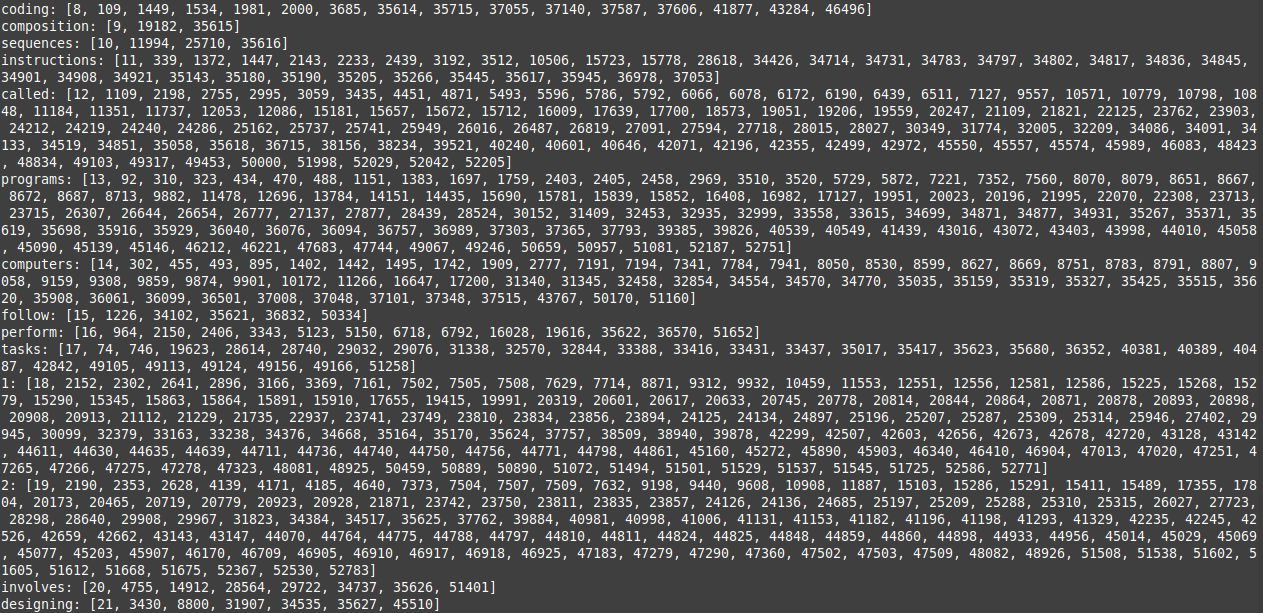

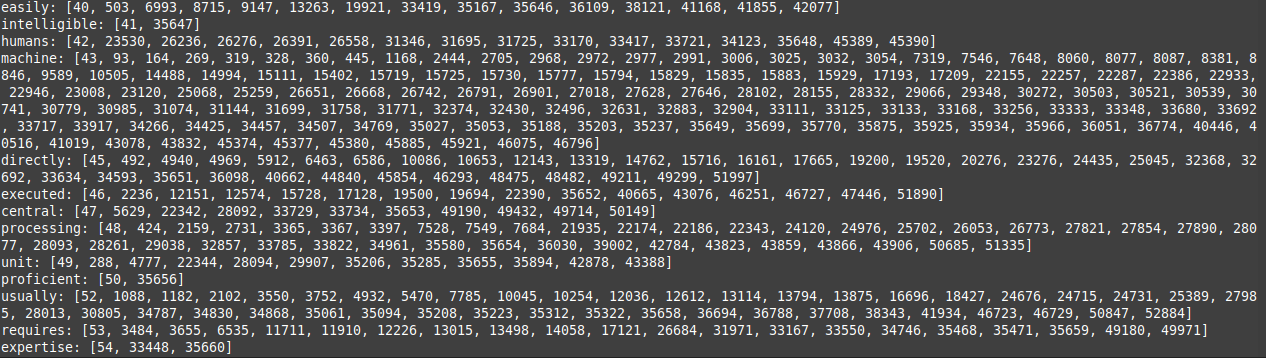

# Μέρος 4ο: Μηχανή Αναζήτησης -- merged.py

Ζητείται από τον χρήστη να δώσει ένα ερώτημα (query) με τις λέξεις να χωρίζονται με κόμμα. Ύστερα του δίνεται η δυνατότητα να επιλέξει ανάμεσα σε: Boolean Retrieval, TF-IDF και Okapi BM25.

## Boolean Retrieval
Το ερώτημα (query) διασπάται αρχικά σε tokens (terms). Ύστερα:

### Αν βρεθεί "and":
Αν υπάρχει "and" στο ερώτημα, το πρόγραμμα βρίσκει κάθε όρο του ερωτήματος και τα άρθρα που του αντιστοιχούν στο ευρετήριο. Ύστερα εκτελείται πράξη AND μεταξύ των αποτελεσμάτων που προέκυψαν για τους όρους. Δηλαδή το τελικό αποτέλεσμα είναι τα άρθρα που αντιστοιχούν σε όλους τους όρους. Αν σε κάποιο άρθρο δεν αναφέρονται όλοι οι όροι, αυτό αφαιρείται.

### Αν βρεθεί "or":
Το πρόγραμμα εκτελεί αντίστοιχη λειτουργία με την παραπάνω περίπτωση, με διαφορά την πράξη που εκτελείται αφού βρεθούν τα άρθρα. Εκτελείται πράξη OR. Δηλαδή το τελικό αποτέλεσμα είναι όλα τα άρθρα που βρέθηκαν, είτε αναφέρονται όλοι οι όροι μέσα σε αυτά, είτε μόνο ένας.

### Αν βρεθεί "not":
Το πρόγραμμα σε αυτή την περίπτωση, αφού βρει τα άρθρα που αντιστοιχούν στον όρο του ερωτήματος, τα αφαιρεί από το τελικό αποτέλεσμα.

### TF-IDF:
Αρχικά τα άρθρα μετατρέπονται σε έναν πίνακα TF-IDF, δηλαδή στον πίνακα θα υπάρχουν οι αριθμοί ταυτοποίησης των άρθρων και οι όροι που περιέχονται στα άρθρα, μετά από υπολογισμούς με βάση τον αλγόριθμο TF-IDF. Η ίδια μετατροπή γίνεται και για το ερώτημα (query) του χρήστη. Ύστερα υπολογίζεται το πόσο μοιάζουν οι δύο πίνακες ώστε να υπολογισθεί ο βαθμός στον οποίο σχετίζεται ένα άρθρο με τον όρο που αναζητείται. Τα αποτελέσματα ταξινομούνται με φθίνουσα σειρά ώστε να βρεθεί το άρθρο με την μεγαλύτερη σχετικότητα.

### Okapi BM25:
Τα άρθρα χωρίζονται και εδώ σε tokens προτού εκτελεσθούν οι πράξεις του αλγορίθμου Okapi BM25 σε αυτά. Χωρίζεται και το ερώτημα του χρήστη σε tokens. Ύστερα υπολογίζεται ο βαθμός στον οποίο σχετίζεται το κάθε άρθρο με τον όρο (ή όρους) του ερωτήματος. Τα αποτελέσματα ταξινομούνται με φθίνουσα σειρά για να βρεθεί ο υψηλότερος βαθμός, δηλαδή να βρεθεί το πιο σχετικό άρθρο.

Στο τέλος παρουσιάζονται τα αποτελέσματα. Εάν έχει επιλεχθεί Boolean Retrieval, εκτυπτώνονται τα ID των άρθρων. Αλλιώς (αν επιλέχθηκε TF-IDF ή BM25) εκτυπώνονται τα ID των άρθρων και το score που δείχνει την σχετικότητά τους.

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
from collections import defaultdict
import json
from nltk.tokenize import RegexpTokenizer

# Φόρτωση δεδομένων (επεξεργασμένων άρθρων)
with open("processed_data.json", "r", encoding="utf-8") as file:
    documents = json.load(file)

if isinstance(documents, list):
    doc_ids = list(range(len(documents)))  # Κάνοντας την λιστα λεξικό
    doc_texts = documents
elif isinstance(documents, dict):
    doc_ids = list(documents.keys())
    doc_texts = list(documents.values())
else:
    raise ValueError("Unsupported JSON structure")


def create_inverted_index(documents):
    inverted_index = defaultdict(list)
    for doc_id, text in zip(doc_ids, documents):
        tokens = text.split()
        for token in set(tokens):
            inverted_index[token].append(doc_id)
    return inverted_index

inverted_index = create_inverted_index(doc_texts)

def tokenization(query):
    # Τα γράμματα του ερωτήματος μετατρέπονται σε μικρά  
    lowered_query = query.lower()

    # Χωρίζεται το ερώτημα σε tokens και αφαιρούνται σημεία στίξης και άλλα σύμβολα με τον tokenizer της NLTK
    tokenizer = RegexpTokenizer(r'\w+')

    query_tokens = tokenizer.tokenize(lowered_query)

    return query_tokens

def boolean_retrieval(query, inverted_index, operator="AND"):
    terms = query.split()
    if operator == "AND":
        result = set(inverted_index.get(terms[0], []))
        for term in terms[1:]:
            result &= set(inverted_index.get(term, []))
        return list(result)
    elif operator == "OR":
        result = set()
        for term in terms:
            result |= set(inverted_index.get(term, []))
        return list(result)
    elif operator == "NOT":
        result = set(doc_ids)
        for term in terms:
            result -= set(inverted_index.get(term, []))
        return list(result)
    else:
        raise ValueError("Invalid Boolean operator")

# Αλγόριθμος TF-IDF 
def tfidf_ranking(query, documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    query_vector = vectorizer.transform([query])
    scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    ranked_indices = np.argsort(scores)[::-1]
    return [(doc_ids[i], scores[i]) for i in ranked_indices]

# Αλγόριθμος BM25
def bm25_ranking(query, documents):
    tokenized_docs = [doc.split() for doc in documents]
    bm25 = BM25Okapi(tokenized_docs)
    tokenized_query = query.split()
    scores = bm25.get_scores(tokenized_query)
    ranked_indices = np.argsort(scores)[::-1]
    return [(doc_ids[i], scores[i]) for i in ranked_indices]

# Queries χρήστη
queries = input("Enter your search queries (separated by commas): ").split(",")

# Επιλογή αλγορίθμου
print("\nSelect retrieval algorithm:")
print("1. Boolean Retrieval (AND)")
print("2. Boolean Retrieval (OR)")
print("3. Boolean Retrieval (NOT)")
print("4. TF-IDF")
print("5. BM25")
choice = int(input("Enter choice (1/2/3/4/5): "))

# Εκτέλεση για κάθε ερώτημα
for query in queries:
    query = query.strip()
    if choice == 1:
        results = boolean_retrieval(query, inverted_index, operator="AND")
    elif choice == 2:
        results = boolean_retrieval(query, inverted_index, operator="OR")
    elif choice == 3:
        results = boolean_retrieval(query, inverted_index, operator="NOT")
    elif choice == 4:
        results = tfidf_ranking(query, doc_texts)
    elif choice == 5:
        results = bm25_ranking(query, doc_texts)
    else:
        print("Invalid choice")
        results = []

    # Αποτελέσματα για κάθε ερώτημα
    print(f"\nResults for query: \"{query}\"")
    if choice in [1, 2, 3]:
        for doc_id in results:
            print(f"Document ID: {doc_id}")
    else:
        for rank, (doc_id, score) in enumerate(results, start=1):
            print(f"{rank}. Document ID: {doc_id}, Score: {score:.4f}")

## Δοκιμές για Boolean Retrieval

### OR:

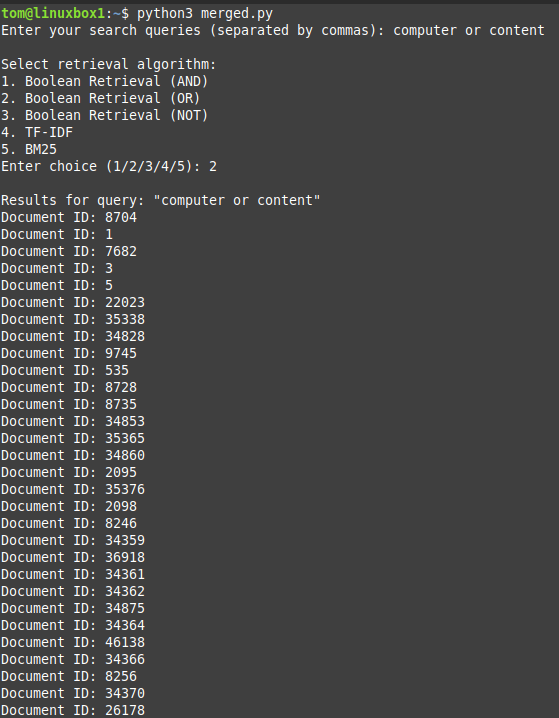

### NOT:

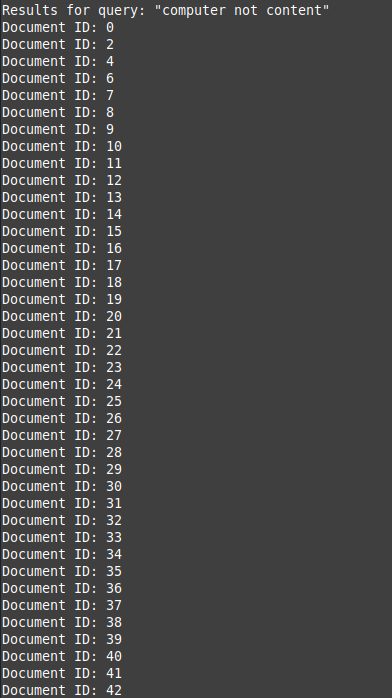

### Δοκιμές για TF-IDF

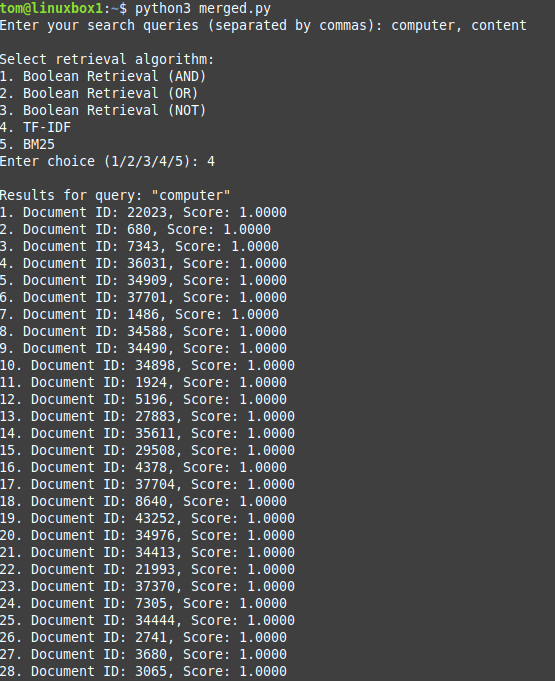 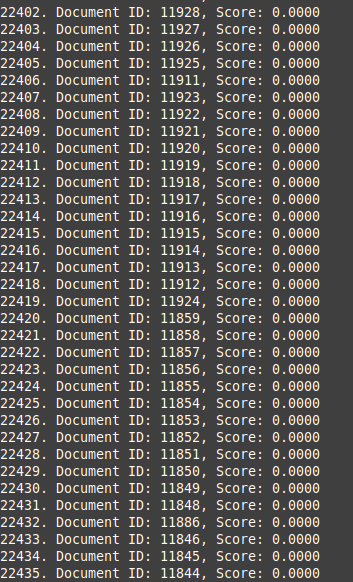

### Δοκιμές για BM25

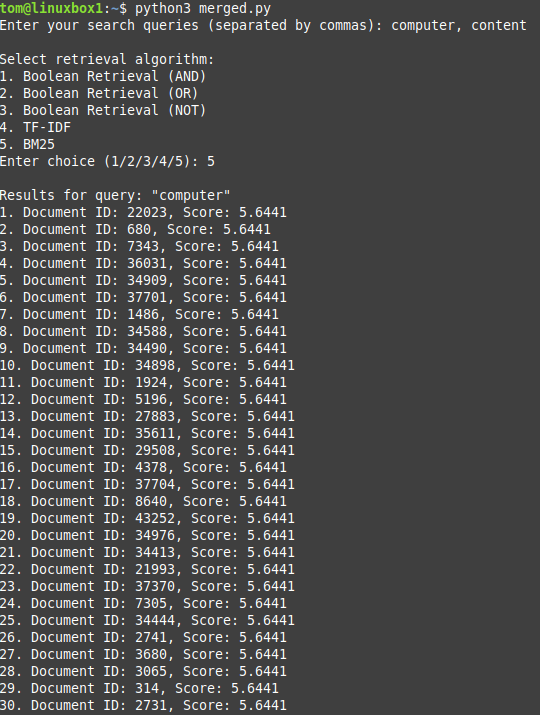 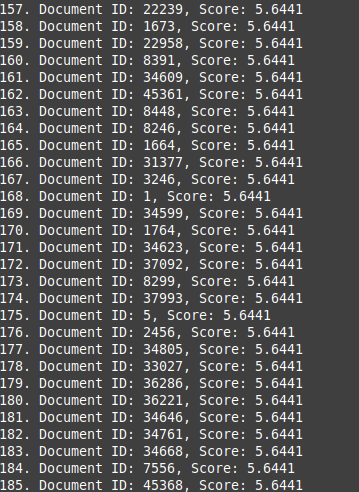